# Permeation barrier model

Base model for shield permeation barrier modeling

In [1]:
import festim as F
import numpy as np
from timelag_analysis_functions import *

In [2]:
print(F.__version__)

2.0a7


In [3]:
my_model = F.HydrogenTransportProblem()

substrate_thick = 1e-3  # m
# Temperature will be set after defining T_func in next cell
w_atom_density = 6.3e28  # atom/m3
# SS_atom_density = 8.5e28  # atom/m3


tungsten = F.Material(
    D_0=4.1e-7,
    E_D=0.39,
    K_S_0=1.87e24,
    E_K_S=1.04,
    )

# # actually stainless steel
# tungsten = F.Material(
#     D_0=5.91e-7,
#     E_D=0.56,
#     K_S_0=1.35e22,
#     E_K_S=0.29,
#     )

In [4]:
import ufl
import math

# ---- User inputs ----
runs_per_temp = 2 # number of runs at each temperature

P_run = 1.0e5 # pressure during runs (Pa)
P_bake = 0.0 # pressure during bakes (Pa)

# Time for pressure to decrease from P_run to P_bake (sinusoidal ramp)
decrease_time = 720 * 60  # seconds (720 minutes = 12 hours)

base_run_length = 1.3e5 # s (base run length for 600K)
temperatures = [600, 550, 500, 550, 600]  # K

run_length_map = {
    600: base_run_length,
    550: base_run_length * 5,
    500: base_run_length * 25,
}

# Bake length is always 3x the run length for each temperature
bake_length_multiplier = 3
bake_length_map = {temp: length * bake_length_multiplier for temp, length in run_length_map.items()}


# ---- Build milestones and temperature schedule ----
milestones = []
temp_schedule = []  # list of (time_end, temperature, phase) tuples
t_curr = 0.0

for temp_idx, temp in enumerate(temperatures):
    run_length = run_length_map[temp]
    bake_length = bake_length_map[temp]
    
    for run_idx in range(runs_per_temp):
        # end of run
        t_curr += run_length
        milestones.append(t_curr)
        temp_schedule.append((t_curr, temp, 'run'))
        
        # end of bake (except after the very last run)
        is_last_run = (temp_idx == len(temperatures) - 1) and (run_idx == runs_per_temp - 1)
        if not is_last_run:
            t_curr += bake_length
            milestones.append(t_curr)
            temp_schedule.append((t_curr, temp, 'bake'))

# total simulated time
final_time = t_curr

print(f"Total runs: {len(temperatures) * runs_per_temp}")
print(f"Total time: {final_time:.2e} s ({final_time/3600:.1f} hours)")
print(f"Milestones: {len(milestones)}")
print(f"\nRun and bake lengths by temperature (bake = {bake_length_multiplier}x run):")
for temp in run_length_map.keys():
    run_len = run_length_map[temp]
    bake_len = bake_length_map[temp]
    print(f"  {temp}K: run={run_len:.2e} s ({run_len/3600:.1f} hr), bake={bake_len:.2e} s ({bake_len/3600:.1f} hr)")
print(f"\nTemperature schedule:")
for i, (t_end, temp, phase) in enumerate(temp_schedule):
    print(f"  Segment {i+1}: {phase:4s} @ {temp}K until t={t_end:.2e} s ({t_end/3600:.1f} hr)")
print(f"\nPressure ramp (run→bake): {decrease_time} s ({decrease_time/60:.1f} min)")


# ==============================================================================
# PRESSURE FUNCTION (with sinusoidal ramp from run to bake)
# ==============================================================================
def _build_pressure_expr(t, temp_schedule, P_run, P_bake, decrease_time):
    """
    Builds nested ufl.conditional expression for pressure with sinusoidal ramp.
    
    When transitioning from run to bake, pressure decreases smoothly over 
    `decrease_time` seconds using a cosine profile (zero slope at start and end).
    
    Formula: P = P_run - (P_run - P_bake) * 0.5 * (1 - cos(π * progress))
    """
    expr = P_run  # fallback after last milestone: run
    
    for k in reversed(range(len(temp_schedule))):
        t_end, _, phase = temp_schedule[k]
        
        if phase == 'run':
            expr = ufl.conditional(
                ufl.le(t, t_end),
                P_run,
                expr,
            )
        else:  # phase == 'bake'
            # Find the preceding run's end time (ramp starts here)
            t_run_end = temp_schedule[k-1][0] if k > 0 else 0.0
            t_ramp_end = t_run_end + decrease_time
            
            # Sinusoidal ramp: P = P_run - (P_run - P_bake) * 0.5 * (1 - cos(π * progress))
            progress = (t - t_run_end) / decrease_time
            ramp_expr = P_run - (P_run - P_bake) * 0.5 * (1 - ufl.cos(math.pi * progress))
            
            # During bake phase:
            # - If t <= t_ramp_end: we're in the sinusoidal ramp
            # - If t > t_ramp_end: pressure is P_bake (fully evacuated)
            bake_expr = ufl.conditional(
                ufl.le(t, t_ramp_end),
                ramp_expr,
                P_bake,
            )
            
            expr = ufl.conditional(
                ufl.le(t, t_end),
                bake_expr,
                expr,
            )
    
    return expr


def P_up(t):
    """
    Pressure function: P_run during runs, sinusoidal ramp to P_bake during bakes.
    """
    return _build_pressure_expr(t, temp_schedule, P_run, P_bake, decrease_time)


# ==============================================================================
# TEMPERATURE FUNCTION
# ==============================================================================
def T_func(t):
    """
    Temperature function with FESTIM-compatible signature.
    """
    # Check each segment from the beginning forwards
    for k in range(len(temp_schedule)):
        t_end, temp, _ = temp_schedule[k]
        if t <= t_end:
            return temp

    # Fallback: return last temperature
    return temp_schedule[-1][1]


# ==============================================================================
# VERIFY TEMPERATURE FUNCTION
# ==============================================================================
print("\n" + "="*60)
print("Temperature function verification:")
print("="*60)
test_times = [5000, 100000, 220000, 300000, 440000, 600000, 660000, 800000, 870000]
for t_test in test_times:
    T_result = T_func(t_test)
    # Find expected segment
    for i, (t_end, temp, phase) in enumerate(temp_schedule):
        if t_test <= t_end:
            expected = temp
            seg_num = i + 1
            break
    status = "✓" if T_result == expected else "✗"
    print(f"  t={t_test:>7}s → T_func returns {T_result}K (segment {seg_num}: {expected}K) {status}")

Total runs: 10
Total time: 3.81e+07 s (10580.6 hours)
Milestones: 19

Run and bake lengths by temperature (bake = 3x run):
  600K: run=1.30e+05 s (36.1 hr), bake=3.90e+05 s (108.3 hr)
  550K: run=6.50e+05 s (180.6 hr), bake=1.95e+06 s (541.7 hr)
  500K: run=3.25e+06 s (902.8 hr), bake=9.75e+06 s (2708.3 hr)

Temperature schedule:
  Segment 1: run  @ 600K until t=1.30e+05 s (36.1 hr)
  Segment 2: bake @ 600K until t=5.20e+05 s (144.4 hr)
  Segment 3: run  @ 600K until t=6.50e+05 s (180.6 hr)
  Segment 4: bake @ 600K until t=1.04e+06 s (288.9 hr)
  Segment 5: run  @ 550K until t=1.69e+06 s (469.4 hr)
  Segment 6: bake @ 550K until t=3.64e+06 s (1011.1 hr)
  Segment 7: run  @ 550K until t=4.29e+06 s (1191.7 hr)
  Segment 8: bake @ 550K until t=6.24e+06 s (1733.3 hr)
  Segment 9: run  @ 500K until t=9.49e+06 s (2636.1 hr)
  Segment 10: bake @ 500K until t=1.92e+07 s (5344.4 hr)
  Segment 11: run  @ 500K until t=2.25e+07 s (6247.2 hr)
  Segment 12: bake @ 500K until t=3.22e+07 s (8955.6 hr)

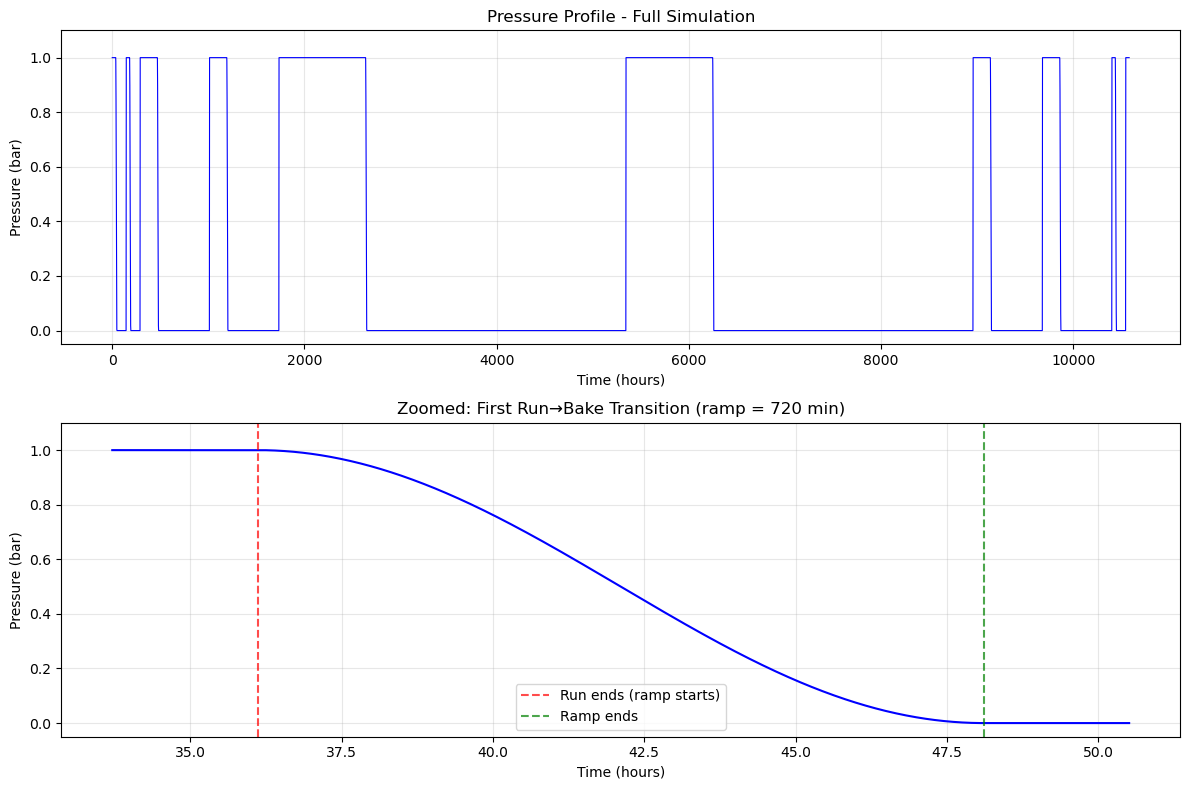

In [5]:
# Plot pressure profile over time
import matplotlib.pyplot as plt

def P_up_plot(t_val):
    """Python version of pressure function for plotting (with sinusoidal ramp)."""
    for k in range(len(temp_schedule)):
        t_end, _, phase = temp_schedule[k]
        
        if t_val <= t_end:
            if phase == 'run':
                return P_run
            else:  # bake
                t_run_end = temp_schedule[k-1][0] if k > 0 else 0.0
                t_ramp_end = t_run_end + decrease_time
                if t_val <= t_ramp_end:
                    # Sinusoidal ramp
                    progress = (t_val - t_run_end) / decrease_time
                    return P_run - (P_run - P_bake) * 0.5 * (1 - math.cos(math.pi * progress))
                return P_bake
    return P_run

# Generate pressure profile
t_plot = np.linspace(0, final_time, 10000)
P_plot = np.array([P_up_plot(t) for t in t_plot])

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Top plot: full simulation
axes[0].plot(t_plot / 3600, P_plot / 1e5, 'b-', linewidth=0.8)
axes[0].set_xlabel('Time (hours)')
axes[0].set_ylabel('Pressure (bar)')
axes[0].set_title('Pressure Profile - Full Simulation')
axes[0].set_ylim(-0.05, 1.1)
axes[0].grid(True, alpha=0.3)

# Bottom plot: zoom in on first run-to-bake transition
first_run_end = temp_schedule[0][0]
margin = decrease_time * 0.2
zoom_start = first_run_end - margin
zoom_end = first_run_end + decrease_time + margin

t_zoom = np.linspace(zoom_start, zoom_end, 1000)
P_zoom = np.array([P_up_plot(t) for t in t_zoom])

axes[1].plot(t_zoom / 3600, P_zoom / 1e5, 'b-', linewidth=1.5)
axes[1].axvline(x=first_run_end / 3600, color='r', linestyle='--', alpha=0.7, label='Run ends (ramp starts)')
axes[1].axvline(x=(first_run_end + decrease_time) / 3600, color='g', linestyle='--', alpha=0.7, label='Ramp ends')
axes[1].set_xlabel('Time (hours)')
axes[1].set_ylabel('Pressure (bar)')
axes[1].set_title(f'Zoomed: First Run→Bake Transition (ramp = {decrease_time/60:.0f} min)')
axes[1].legend()
axes[1].set_ylim(-0.05, 1.1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Validate that the UFL boundary condition matches the Python plotting function
import dolfinx
from mpi4py import MPI

# Create a simple 1D mesh for testing
test_mesh = dolfinx.mesh.create_unit_interval(MPI.COMM_WORLD, 10)

# Create a time constant that we can update
t_test = dolfinx.fem.Constant(test_mesh, 0.0)

# Build the UFL pressure expression
P_ufl_expr = P_up(t_test)

# Test at various time points around the first transition (including ramp)
first_run_end = temp_schedule[0][0]
test_times = [
    first_run_end - 1000,                    # Before transition (P_run)
    first_run_end,                            # Exactly at run end (P_run)
    first_run_end + decrease_time * 0.25,    # 25% through ramp
    first_run_end + decrease_time * 0.5,     # 50% through ramp
    first_run_end + decrease_time * 0.75,    # 75% through ramp
    first_run_end + decrease_time,           # End of ramp
    first_run_end + decrease_time + 1000,    # After ramp (P_bake)
]

print("Validation: UFL expression vs Python plotting function")
print("=" * 70)
print(f"{'Time (s)':<20} {'Python P':<15} {'UFL P':<15} {'Match?':<10}")
print("-" * 70)

all_match = True
for t_val in test_times:
    # Python version
    P_python = P_up_plot(t_val)
    
    # UFL version - update the constant and evaluate
    t_test.value = t_val
    
    # Create a Function and interpolate to evaluate UFL expression
    V = dolfinx.fem.functionspace(test_mesh, ("DG", 0))
    P_func = dolfinx.fem.Function(V)
    
    # Create expression for interpolation
    expr = dolfinx.fem.Expression(P_ufl_expr, V.element.interpolation_points())
    P_func.interpolate(expr)
    
    # Get the value (should be constant across the domain)
    P_ufl_val = P_func.x.array[0]
    
    match = abs(P_python - P_ufl_val) < 1e-6
    all_match = all_match and match
    
    print(f"{t_val:<20.1f} {P_python:<15.2f} {P_ufl_val:<15.2f} {'✓' if match else '✗':<10}")

print("-" * 70)
if all_match:
    print("✓ All values match! UFL boundary condition is working correctly.")
else:
    print("✗ Some values don't match! Check the UFL expression.")

Validation: UFL expression vs Python plotting function
Time (s)             Python P        UFL P           Match?    
----------------------------------------------------------------------
129000.0             100000.00       100000.00       ✓         
130000.0             100000.00       100000.00       ✓         
140800.0             85355.34        85355.34        ✓         
151600.0             50000.00        50000.00        ✓         
162400.0             14644.66        14644.66        ✓         
173200.0             0.00            0.00            ✓         
174200.0             0.00            0.00            ✓         
----------------------------------------------------------------------
✓ All values match! UFL boundary condition is working correctly.


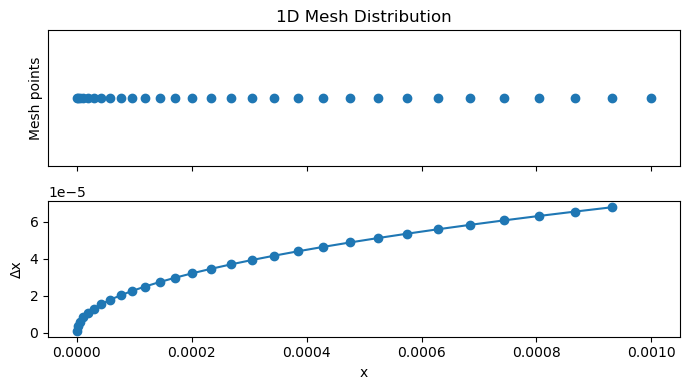

Solving HydrogenTransportProblem:   9%|▉         | 3.61M/38.1M [00:54<05:29, 105kit/s]   

KeyboardInterrupt: 

In [7]:
# Set the temperature function (defined in previous cell)
my_model.temperature = T_func

# Set up model
H, trapped_H1, trapped_H2, empty_trap1, empty_trap2 = define_species(my_model, w_atom_density)


N = 30
s = np.linspace(0, 1, N)

# Left-concentrated mesh using power law: higher exponent = more concentration at left (x=0)
mesh_concentration = 2.0  # exponent for mesh grading (1.0 = uniform, 2.0+ = left-concentrated)
vertices = substrate_thick * s**mesh_concentration

# # Cosine mesh (concentrates at both ends)
# vertices = substrate_thick * 0.5 * (1 - np.cos(np.pi * s))

# # Uniform mesh
# vertices = np.linspace(0, substrate_thick, num=N)

plot_1d_mesh(vertices)

my_model.mesh = F.Mesh1D(vertices)

volume_subdomain, left_boundary, right_boundary = define_BCs_and_initial_conditions(
    my_model, tungsten, substrate_thick, H, P_up
)

define_trapping_reactions(my_model, H, trapped_H1, trapped_H2, empty_trap1, empty_trap2, volume_subdomain, w_atom_density)

settings(
    my_model, 
    final_time, 
    growth_factor=1.003,
    cutback_factor=0.9,
    max_stepsize=1000,
    milestones=milestones,
    pre_milestone_duration = 1,
    post_milestone_duration = 1000,
    initial_value = 50
)

permeation_flux = F.SurfaceFlux(field=H, surface=right_boundary)

export_folder = "results/timelag"
filename = export_folder + "/hydrogen_concentration.xdmf"

xdmf_exports = [
    F.XDMFExport(field=H, filename=filename)
]

my_model.exports = [permeation_flux] + xdmf_exports

total_trapped_H1 = F.TotalVolume(field=trapped_H1, volume=volume_subdomain)

my_model.initialise()

# Set the function name for XDMF export (for ParaView compatibility)
H.post_processing_solution.name = "H"

my_model.run()

In [8]:
# Close XDMF writers to release file locks
for export in my_model.exports:
    if hasattr(export, '_writer') and export._writer is not None:
        export._writer.close()
        export._writer = None

# Fix XDMF file for ParaView compatibility (remove XInclude, use absolute paths)
def fix_xdmf_for_paraview(xdmf_path):
    """Fix XDMF file to work with ParaView by removing XInclude and using absolute paths."""
    import re
    from pathlib import Path
    
    xdmf_path = Path(xdmf_path)
    h5_path = xdmf_path.with_suffix('.h5')
    abs_h5_path = str(h5_path.resolve())
    h5_filename = xdmf_path.stem + '.h5'
    
    with open(xdmf_path, 'r') as f:
        content = f.read()
    
    # First, replace relative H5 paths with absolute paths (before xi:include replacement)
    # Only replace when it's a relative path (not already absolute)
    content = re.sub(
        rf'(?<!/){re.escape(h5_filename)}:',
        f'{abs_h5_path}:',
        content
    )
    
    # Get mesh info from the first Grid element
    topo_match = re.search(
        r'<Topology TopologyType="(\w+)" NumberOfElements="(\d+)" NodesPerElement="(\d+)">\s*'
        r'<DataItem Dimensions="(\d+ \d+)" NumberType="(\w+)" Format="HDF">([^<]+)</DataItem>\s*'
        r'</Topology>',
        content
    )
    geom_match = re.search(
        r'<Geometry GeometryType="(\w+)">\s*'
        r'<DataItem Dimensions="(\d+ \d+)" Format="HDF">([^<]+)</DataItem>\s*'
        r'</Geometry>',
        content
    )
    
    if topo_match and geom_match:
        topo_type, topo_nelems, topo_nodes, topo_dims, topo_numtype, _ = topo_match.groups()
        geom_type, geom_dims, _ = geom_match.groups()
        
        # Build replacement topology/geometry with absolute paths
        replacement = f'''        <Topology TopologyType="{topo_type}" NumberOfElements="{topo_nelems}" NodesPerElement="{topo_nodes}">
          <DataItem Dimensions="{topo_dims}" NumberType="{topo_numtype}" Format="HDF">{abs_h5_path}:/Mesh/mesh/topology</DataItem>
        </Topology>
        <Geometry GeometryType="{geom_type}">
          <DataItem Dimensions="{geom_dims}" Format="HDF">{abs_h5_path}:/Mesh/mesh/geometry</DataItem>
        </Geometry>'''
        
        # Replace all xi:include with inlined topology/geometry
        content = re.sub(
            r'\s*<xi:include xpointer="xpointer\([^)]+\)" />',
            '\n' + replacement,
            content
        )
    
    with open(xdmf_path, 'w') as f:
        f.write(content)
    
    print(f"Fixed XDMF file for ParaView: {xdmf_path}")

fix_xdmf_for_paraview(filename)
print("XDMF file is ready for ParaView")

Fixed XDMF file for ParaView: results/timelag/hydrogen_concentration.xdmf
XDMF file is ready for ParaView


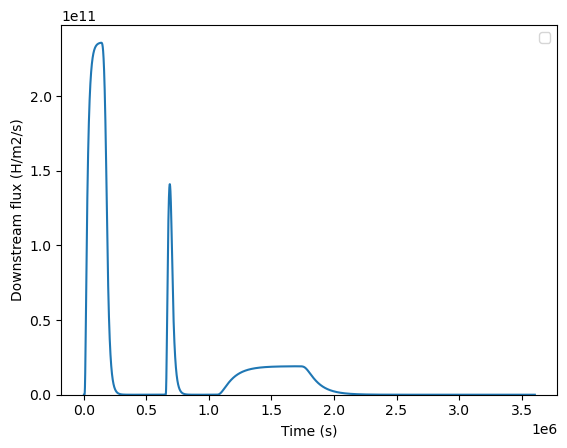

In [9]:
times = permeation_flux.t

import matplotlib.pyplot as plt

plt.plot(times, np.abs(permeation_flux.data))
plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")
plt.legend()
plt.show()

Available timesteps: 7595
First few: ['1000549_4294335365', '10007_768613571478', '100136_66022254761', '1001549_4294335365', '1002549_4294335365']
Last few: ['996549_42943353648', '997549_42943353648', '99787_298327564931', '998549_42943353648', '999549_42943353648']


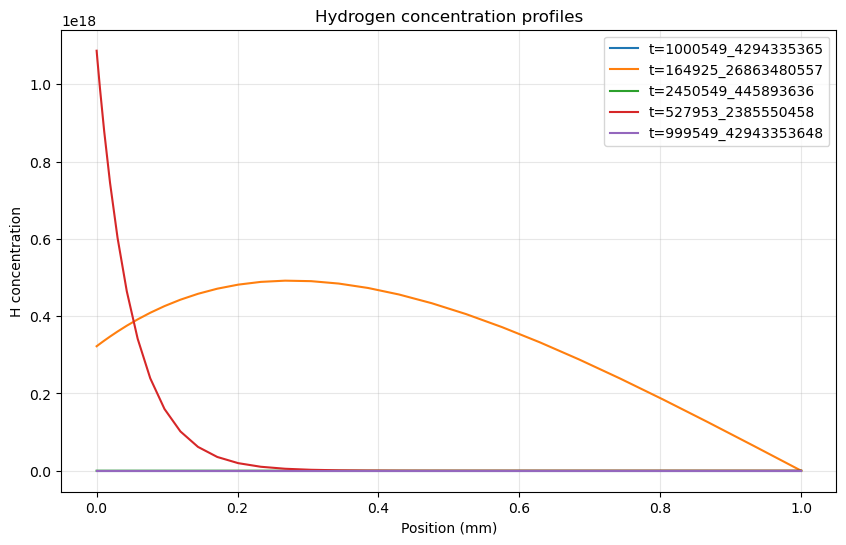

In [12]:
# Visualize concentration profile using h5py + matplotlib (no ParaView needed)
import h5py
import matplotlib.pyplot as plt
import numpy as np



# closes writer so can be viewed in paraview
for export in my_model.exports:
    if hasattr(export, '_writer') and export._writer is not None:
        export._writer.close()
        export._writer = None




h5_path = "results/timelag/hydrogen_concentration.h5"

with h5py.File(h5_path, 'r') as f:
    # Get mesh geometry (x coordinates)
    geometry = f['/Mesh/mesh/geometry'][:]
    x_coords = geometry[:, 0]  # First column is x
    
    # List available timesteps
    timesteps = list(f['/Function/f'].keys())
    print(f"Available timesteps: {len(timesteps)}")
    print(f"First few: {timesteps[:5]}")
    print(f"Last few: {timesteps[-5:]}")
    
    # Plot a few selected timesteps
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Select ~5 evenly spaced timesteps to plot
    indices = np.linspace(0, len(timesteps)-1, 5, dtype=int)
    
    for idx in indices:
        ts = timesteps[idx]
        conc = f[f'/Function/f/{ts}'][:]
        ax.plot(x_coords * 1e3, conc, label=f't={ts}')
    
    ax.set_xlabel('Position (mm)')
    ax.set_ylabel('H concentration')
    ax.set_title('Hydrogen concentration profiles')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

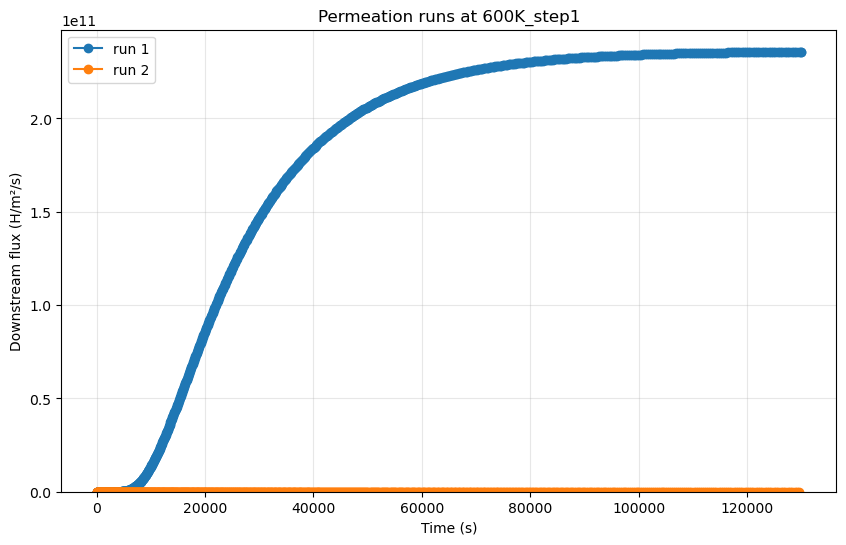

IndexError: index 0 is out of bounds for axis 0 with size 0

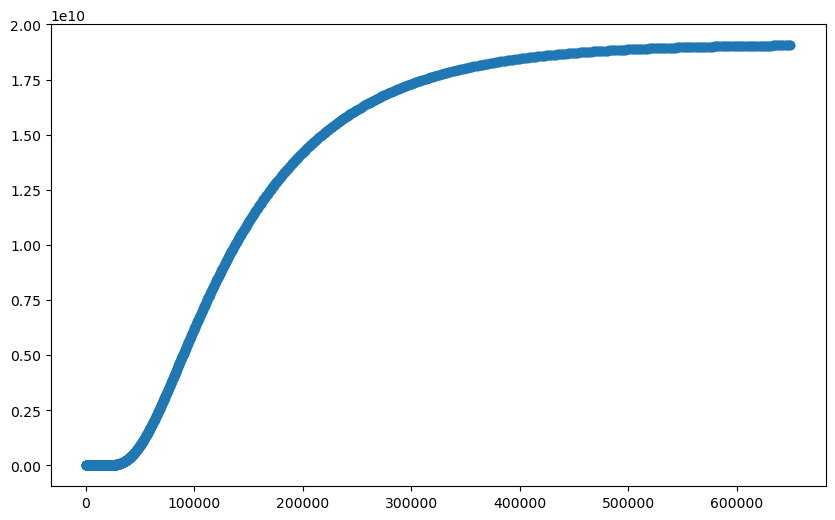

In [14]:
import numpy as np
import matplotlib.pyplot as plt

times = np.asarray(times)
flux  = np.asarray(permeation_flux.data)

# milestones from temp_schedule
milestones_arr = np.asarray(milestones)

# ---------------------------------------
# Split into segments (runs and bakes) with temperature info
# ---------------------------------------
segments = []  # each item: (segment_type, temperature, times, flux)

t_prev = 0.0

for k, (m, temp, phase) in enumerate(temp_schedule):
    mask = (times > t_prev) & (times <= m)
    seg_times = times[mask]
    seg_flux  = flux[mask]
    
    segments.append((phase, temp, seg_times, seg_flux))
    t_prev = m

# ---------------------------------------
# Extract only the runs
# ---------------------------------------
run_segments = [(temp, t, f) for (typ, temp, t, f) in segments if typ == "run"]

# Group runs by temperature step
temp_groups = {}
run_counter = 0

for temp_idx, temp in enumerate(temperatures):
    temp_key = f"{temp}K_step{temp_idx+1}"
    temp_groups[temp_key] = []
    
    for _ in range(runs_per_temp):
        if run_counter < len(run_segments):
            temp_groups[temp_key].append(run_segments[run_counter])
            run_counter += 1

# ---------------------------------------
# Plot each temperature group separately
# ---------------------------------------
for temp_key, runs in temp_groups.items():
    if len(runs) == 0:
        continue
        
    plt.figure(figsize=(10, 6))
    
    for i, (temp, t_seg, f_seg) in enumerate(runs, start=1):
        # Shift ALL runs to start at zero
        t_plot = t_seg - t_seg[0]
        
        plt.plot(t_plot, np.abs(f_seg), "o-", label=f"run {i}")
    
    plt.ylim(bottom=0)
    plt.xlabel("Time (s)")
    plt.ylabel("Downstream flux (H/m²/s)")
    plt.title(f"Permeation runs at {temp_key}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print(f"\nTotal runs plotted: {run_counter}")
print(f"Temperature groups: {list(temp_groups.keys())}")


600K_step1:
  Max flux (run 1): 2.357e+11
  Threshold (5.0%): 1.179e+10


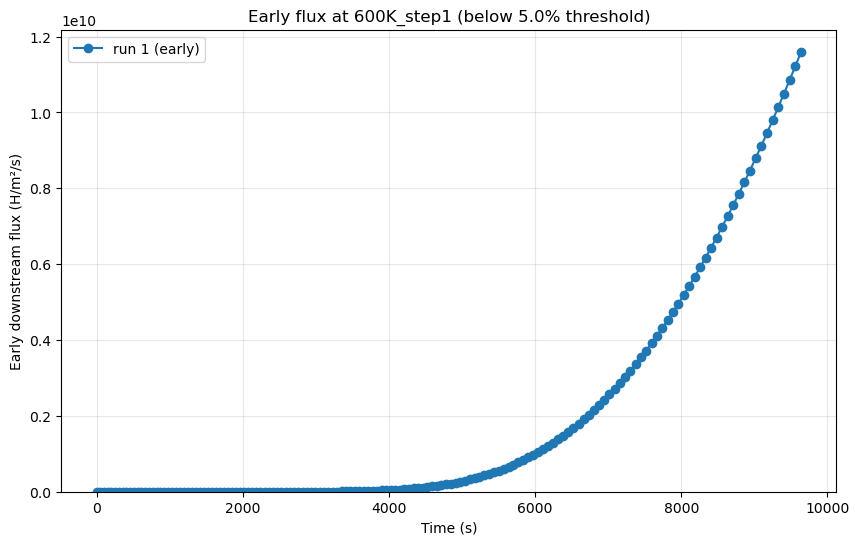


550K_step2:
  Max flux (run 1): 1.905e+10
  Threshold (5.0%): 9.526e+08


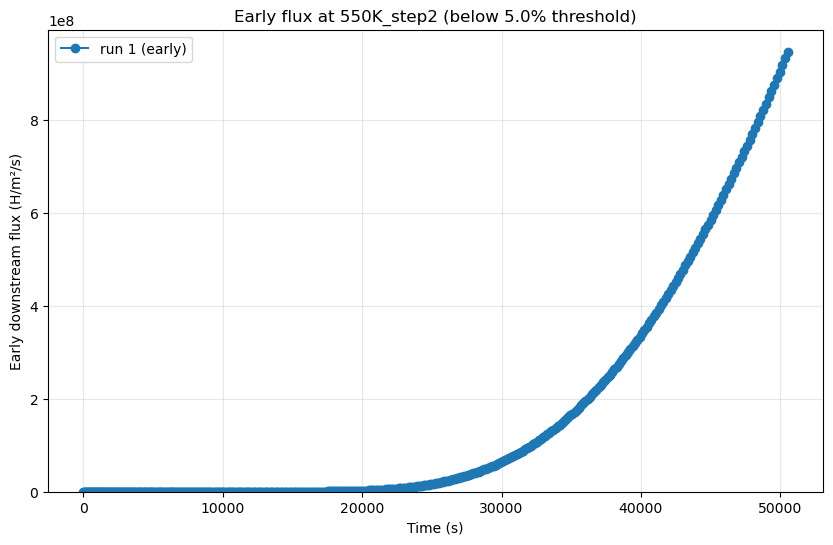


500K_step3:
  Max flux (run 1): 9.064e+08
  Threshold (5.0%): 4.532e+07


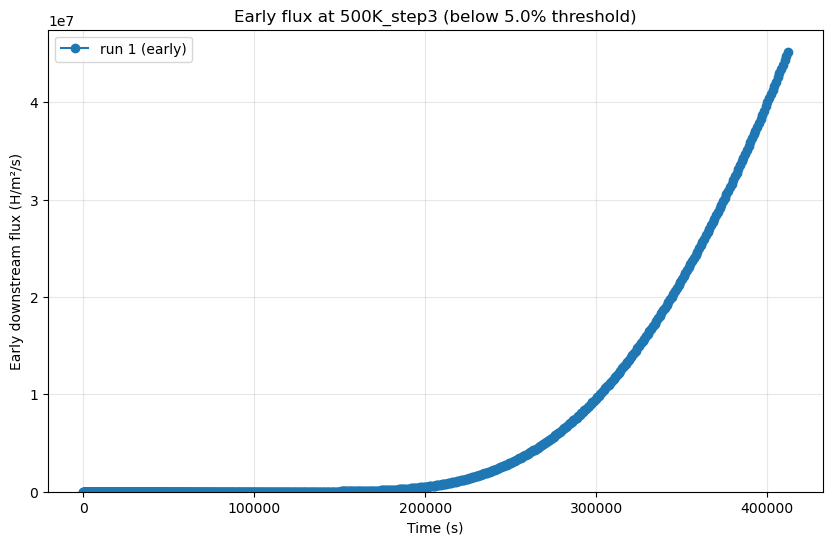


550K_step4:
  Max flux (run 1): 1.905e+10
  Threshold (5.0%): 9.526e+08


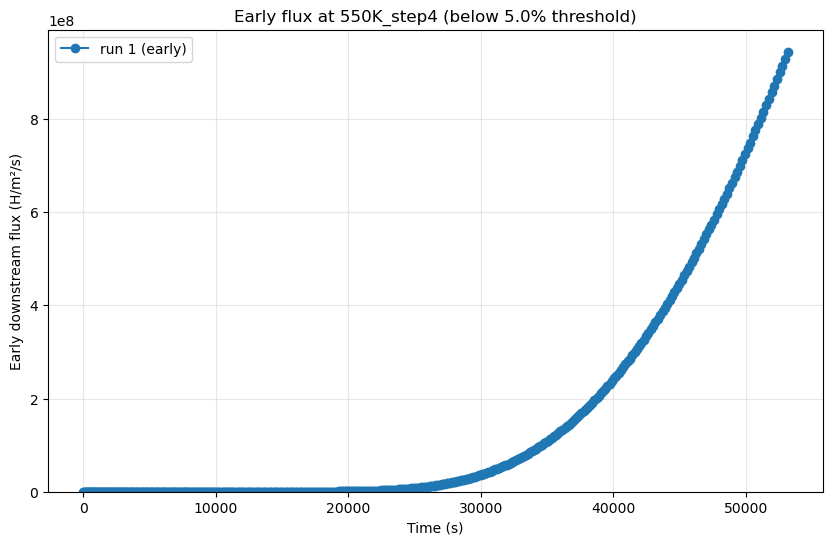


600K_step5:
  Max flux (run 1): 2.357e+11
  Threshold (5.0%): 1.179e+10


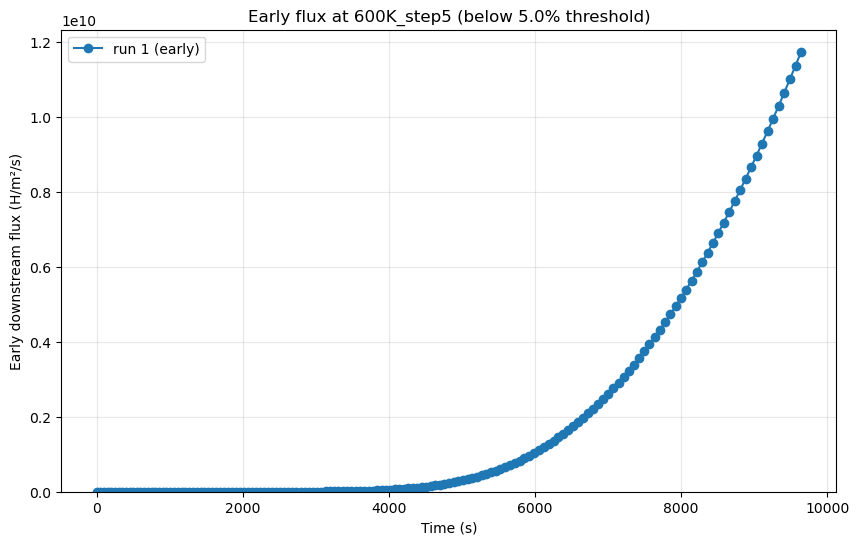

In [ ]:
pct = 0.05  # e.g., 5% of the maximum flux from first run of each temp group

# ---------------------------------------
# Analyze early flux for each temperature group
# ---------------------------------------
temp_early_data = {}  # store early flux data for comparison

for temp_key, runs in temp_groups.items():
    if len(runs) == 0:
        continue
    
    # Get max flux from first run of this temperature group
    first_run_temp, first_run_times, first_run_flux = runs[0]
    max_flux_first = np.max(np.abs(first_run_flux))
    threshold = pct * max_flux_first
    
    print(f"\n{temp_key}:")
    print(f"  Max flux (run 1): {max_flux_first:.3e}")
    print(f"  Threshold ({pct*100:.1f}%): {threshold:.3e}")
    
    # Extract early flux for each run in this group
    early_runs = []
    
    for i, (temp, t_seg, f_seg) in enumerate(runs, start=1):
        f_abs = np.abs(f_seg)
        mask = f_abs <= threshold
        
        t_early = t_seg[mask]
        f_early = f_abs[mask]
        
        early_runs.append((t_early, f_early))
    
    # Store for comparison plot
    temp_early_data[temp_key] = {
        'temperature': first_run_temp,
        'early_runs': early_runs,
        'threshold': threshold
    }
    
    # Plot early portions for this temperature group
    plt.figure(figsize=(10, 6))
    
    for i, (t_early, f_early) in enumerate(early_runs, start=1):
        if len(t_early) == 0:
            continue
        
        # Shift ALL runs to start at zero
        t_plot = t_early - t_early[0]
        
        plt.plot(t_plot, f_early, "-o", label=f"run {i} (early)")
    
    plt.ylim(bottom=0)
    plt.xlabel("Time (s)")
    plt.ylabel("Early downstream flux (H/m²/s)")
    plt.title(f"Early flux at {temp_key} (below {pct*100}% threshold)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Auto-generated comparison pairs:
  600K_step1 vs 600K_step5
  550K_step2 vs 550K_step4



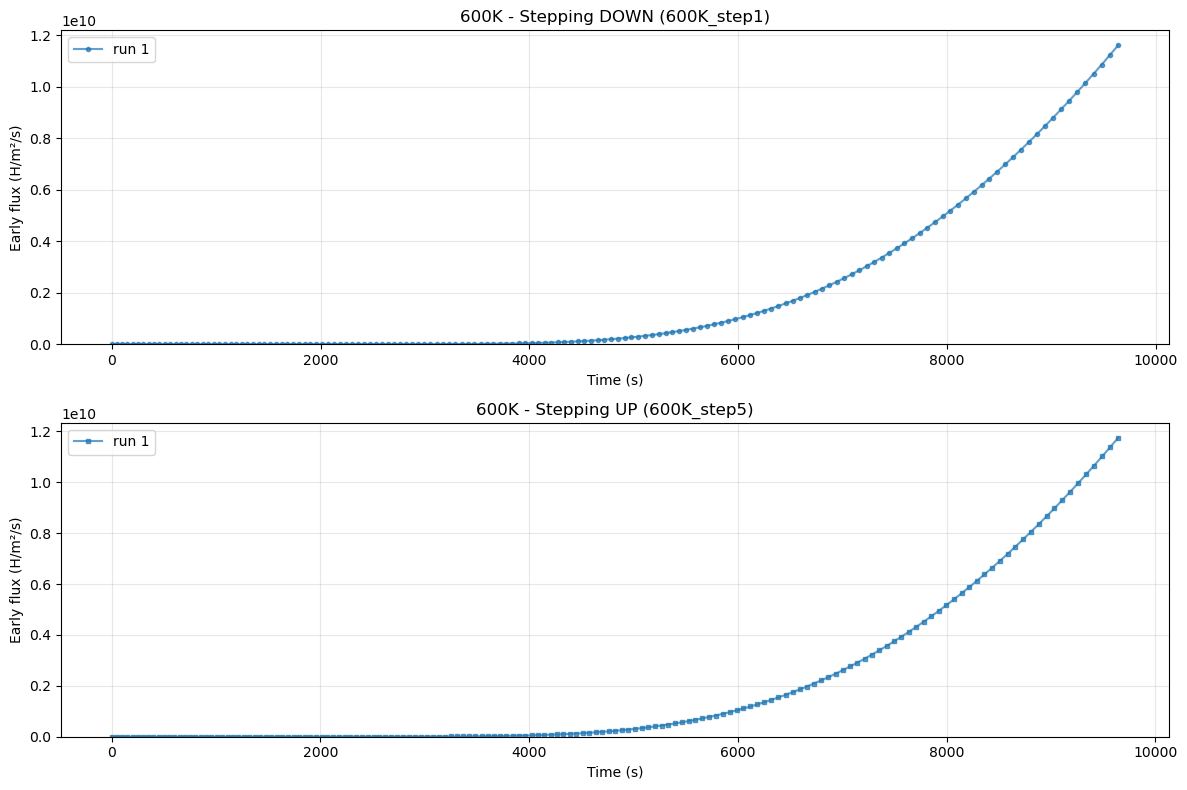


Comparison for 600K:
  Stepping DOWN - Run 1 early phase duration: 9.64e+03 s
  Stepping UP   - Run 1 early phase duration: 9.64e+03 s
  Change: +0.0%
  → Early phase is LONGER when stepping up (more trapped H)


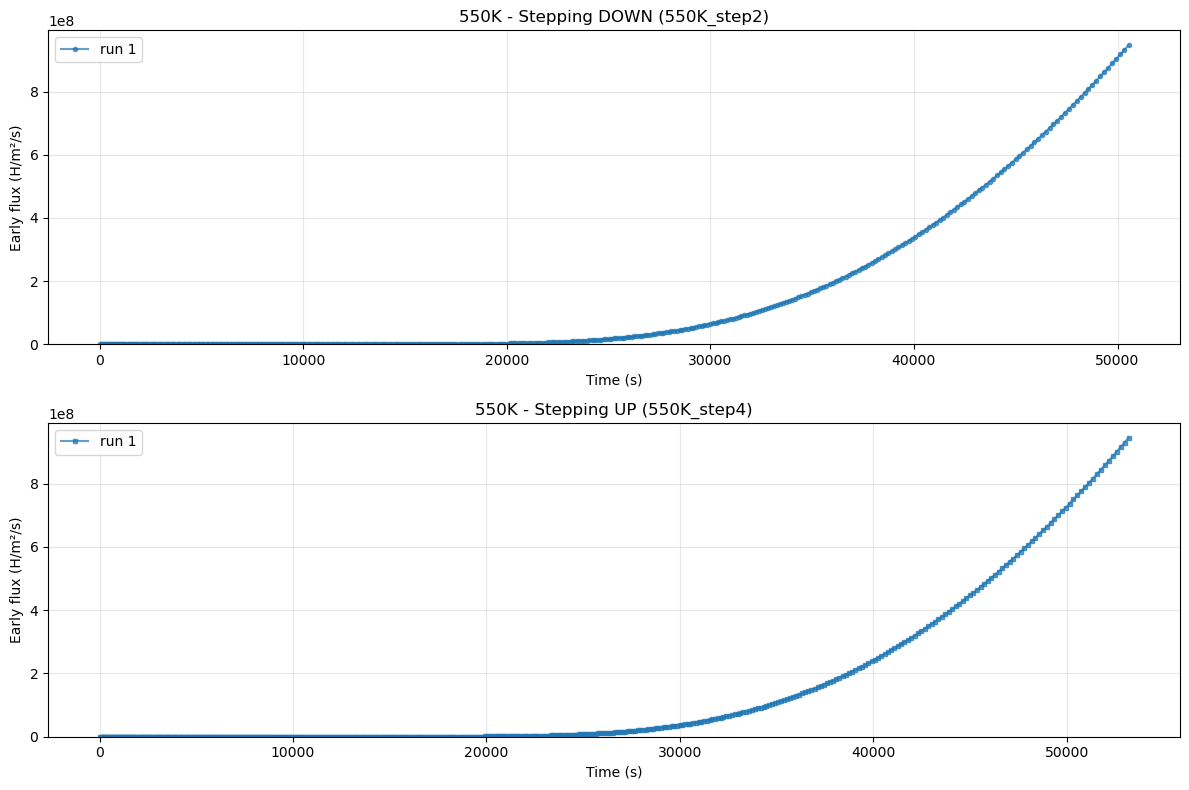


Comparison for 550K:
  Stepping DOWN - Run 1 early phase duration: 5.05e+04 s
  Stepping UP   - Run 1 early phase duration: 5.32e+04 s
  Change: +5.2%
  → Early phase is LONGER when stepping up (more trapped H)


In [ ]:
# ---------------------------------------
# Comparison: Temperature stepping down vs stepping up
# ---------------------------------------
# Dynamically find temperatures that appear more than once
# and compare first occurrence vs last occurrence

# Build comparison pairs automatically from the temperatures list
comparison_pairs = []
seen_temps = {}  # {temp: first_step_index}

for step_idx, temp in enumerate(temperatures):
    step_num = step_idx + 1  # 1-indexed
    if temp not in seen_temps:
        # First occurrence of this temperature
        seen_temps[temp] = step_num
    else:
        # This temperature appeared before - we can compare first vs this occurrence
        first_step = seen_temps[temp]
        # Update to track the latest occurrence for comparison
        # We want to compare first vs LAST occurrence
        pass

# Now find first and last occurrence of each temperature
temp_occurrences = {}  # {temp: [list of step numbers]}
for step_idx, temp in enumerate(temperatures):
    step_num = step_idx + 1
    if temp not in temp_occurrences:
        temp_occurrences[temp] = []
    temp_occurrences[temp].append(step_num)

# Build comparison pairs for temperatures that appear more than once
for temp, steps in temp_occurrences.items():
    if len(steps) >= 2:
        first_step = steps[0]
        last_step = steps[-1]
        down_key = f"{temp}K_step{first_step}"
        up_key = f"{temp}K_step{last_step}"
        comparison_pairs.append((down_key, up_key, f"{temp}K"))

print("Auto-generated comparison pairs:")
for down_key, up_key, temp_label in comparison_pairs:
    print(f"  {down_key} vs {up_key}")
print()

# Now do the comparisons
for down_key, up_key, temp_label in comparison_pairs:
    if down_key not in temp_early_data or up_key not in temp_early_data:
        print(f"Missing data for comparison: {down_key} or {up_key}")
        continue
    
    down_data = temp_early_data[down_key]
    up_data = temp_early_data[up_key]
    
    plt.figure(figsize=(12, 8))
    
    # Plot stepping down (first occurrence of this temperature)
    plt.subplot(2, 1, 1)
    for i, (t_early, f_early) in enumerate(down_data['early_runs'], start=1):
        if len(t_early) == 0:
            continue
        # Shift ALL runs to start at zero
        t_plot = t_early - t_early[0]
        plt.plot(t_plot, f_early, label=f"run {i}", marker='o', markersize=3, alpha=0.7)
    
    plt.ylim(bottom=0)
    plt.xlabel("Time (s)")
    plt.ylabel("Early flux (H/m²/s)")
    plt.title(f"{temp_label} - Stepping DOWN ({down_key})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot stepping up (return to this temperature)
    plt.subplot(2, 1, 2)
    for i, (t_early, f_early) in enumerate(up_data['early_runs'], start=1):
        if len(t_early) == 0:
            continue
        # Shift ALL runs to start at zero
        t_plot = t_early - t_early[0]
        plt.plot(t_plot, f_early, label=f"run {i}", marker='s', markersize=3, alpha=0.7)
    
    plt.ylim(bottom=0)
    plt.xlabel("Time (s)")
    plt.ylabel("Early flux (H/m²/s)")
    plt.title(f"{temp_label} - Stepping UP ({up_key})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison metrics
    print(f"\n{'='*60}")
    print(f"Comparison for {temp_label}:")
    print(f"{'='*60}")
    
    # Compare first runs
    if len(down_data['early_runs'][0][0]) > 0 and len(up_data['early_runs'][0][0]) > 0:
        down_t1, down_f1 = down_data['early_runs'][0]
        up_t1, up_f1 = up_data['early_runs'][0]
        
        down_duration = down_t1[-1] - down_t1[0] if len(down_t1) > 1 else 0
        up_duration = up_t1[-1] - up_t1[0] if len(up_t1) > 1 else 0
        
        print(f"  Stepping DOWN - Run 1 early phase duration: {down_duration:.2e} s")
        print(f"  Stepping UP   - Run 1 early phase duration: {up_duration:.2e} s")
        
        if down_duration > 0:
            change_pct = ((up_duration - down_duration) / down_duration) * 100
            print(f"  Change: {change_pct:+.1f}%")
            
            if up_duration > down_duration:
                print(f"  → Early phase is LONGER when stepping up (more trapped H)")
            elif up_duration < down_duration:
                print(f"  → Early phase is SHORTER when stepping up (less trapped H)")
            else:
                print(f"  → Early phase duration is similar")